### Grupo 3

Heidy Garzón 202020026, 
Carolina Salazar 200923246, 
Nicolás Soto 200814680, 
Fabian Lara 201920066, 
Daniel Lara 201920339

## P1 - Time Series Analysis
Due date: July 18, 2021, 11:59 pm

- The result will be evaluated from a report in Jupyter, which must be found in a public GitHub repository.
- The project must be carried out in the groups assigned in class.
- Use clear and rigorous procedures.
- Due date: July 18, 2021, 11:59 pm, through Bloque Neón + (Upload repository link)
- Projects will not be received after the delivery time or by any other means than the one established.

The project seeks to analyze a question of interest, which can be framed within a context, in order to interpret the results

1. Choosing your time series (Friday July 11th).

For the project, each group must select a dataset of their choice where the analysis can be performed using a time series model. There are many sources of time series data on the Internet. Government agencies are some of the best sources. But be resourceful. It is better to find a data set is from a process that interests you. Use a recent time-series, also try to avoid a tipical stock-price / exchange rates series. The selected time series must be sent no later than Sunday, July 11, 11:59 pm, through Sicua +, for approval.

The analysis of the data must consider:

2. Analysis of the context of the problem and relevance of the analysis: This should answer the question of why it is interesting or important to study the selected data.

3. Understanding the data: Understand and analyze the main components of the time series, for example: seasonality, cyclicity, autocorrelation, behavior of the residuals, among others. Make use of graphs that allow you to understand each of the components clearly.

4. Application of the models in predictions: Correct use of the models seen in class to make predictions related to the problem of interest.

5. Conclusions: The conclusions must be relevant to the problem of interest. Conclusions on the procedures performed are also expected.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

%matplotlib inline
sns.set()

**1. Serie de tiempo seleccionada.**

Escogimos la serie temporal del Índice de calidad del aire, específicamente del estado Delhi de India. Esta base tiene información diaria entre los periodos de 2015 a 2020.

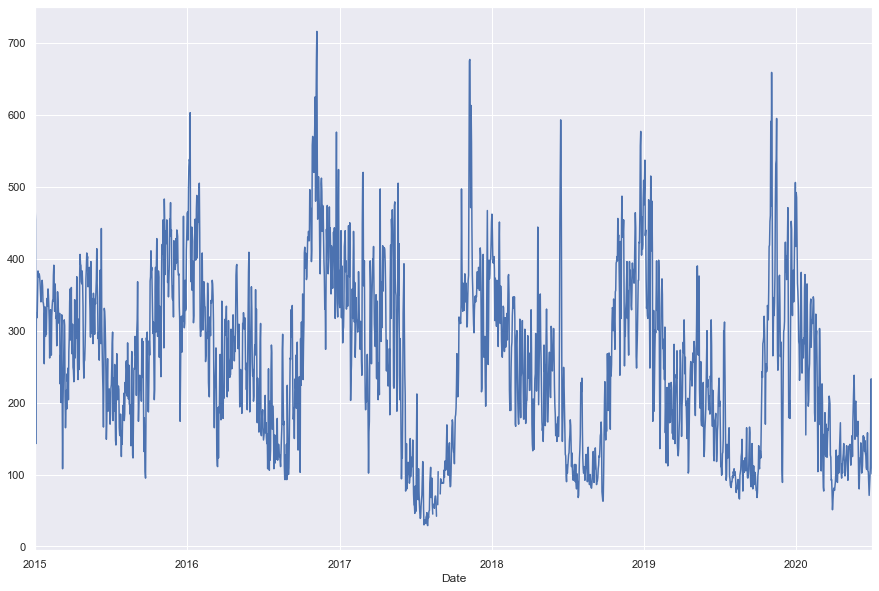

In [11]:
df_serie = pd.read_csv("Air_Quality_Index_Delhi.csv")

df_serie['Date'] = pd.to_datetime(df_serie['Date'])
df_serie.set_index('Date', inplace=True)

df_serie['AQI'].plot(figsize=(15,10))

**2. ¿Por qué escogimos la serie?**

El AQI, Air Quality Index, es un indicador de la contaminación atmosférica que utiliza la medición de partículas (PM2.5 y PM10), ozono, dióxido de nitrógeno, emisiones de dióxido de azufre y monóxido de carbono para cuantificar que tan nocivo es el aire para la salud.

El AQI se evalua de 0 a 500. Un mayor valor de AQI indica que hay un mayor nivel de contaminación en el aire e igualmente, una mayor preocupación sobre los efectos en la salud. 

India es uno de los países más contaminados del mundo. Su capital, Dehli, así como el estado al que pertenece, tienen un nivel de contaminación que excede los límites establecidos por WHO (World Health organization) y que además, ha demostrado ser el principal culpable de la alta incidencia del daño cardiovascular en la población de India (https://www.brookings.edu/blog/future-development/2020/11/25/delhi-the-worlds-most-air-polluted-capital-fights-back/). 

Proponemos utilizar metodologías de series temporales para analizar y estudiar los datos históricos del índice de calidad de aire de esta ciudad capital. De tal forma que el gobierno y los entes regulatorios puedan identificar tendencias que les permitan investigar sobre los posibles factores que contribuyan a la contaminación. Además, tomar acciones frente a la predicción del índice de calidad en el tiempo. En los dos casos, para reducir el impacto de la contaminación del aire en la población de Dehli.

**3. Entendimiento de la serie temporal**

Con el fin de entender y analizar los componentes de nuestra serie de tiempo, analizaremos aspectos como completitud, tendencias, estacionariedad, periodicidad y autocorrelación.

**Completitud:**
    
Se evidencia que la serie temporal cuenta con valores nulos (0.49%) , se usa la función *interpolate* de pandas para imputar estos valores.

In [12]:
df_serie['AQI'].isna().sum() / len(df_serie)

0.004977600796416127

In [13]:
df_serie['AQI'].interpolate(method='time', inplace=True)

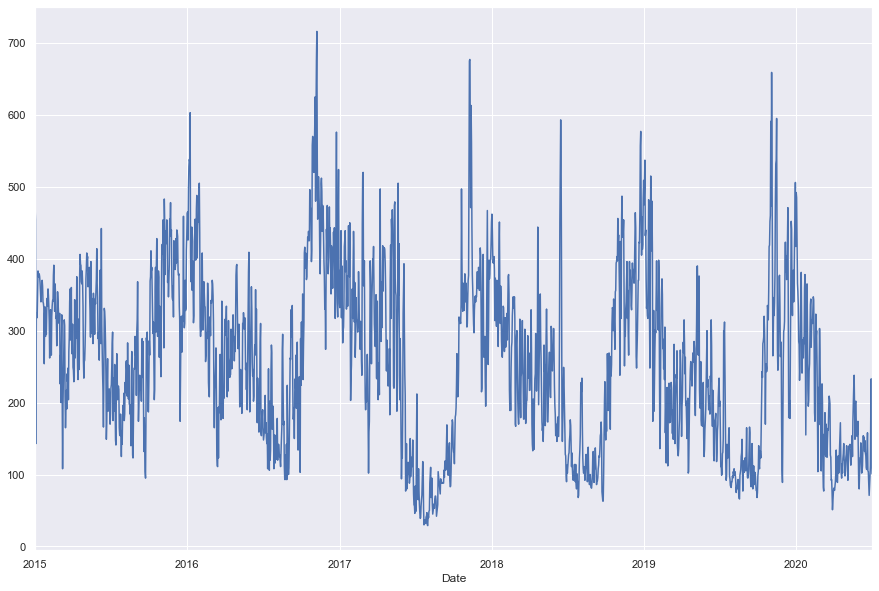

In [14]:
df_serie['AQI'].plot(figsize=(15,10))

**Tendencia:**

A continuación, podemos observar la tendencia de nuestra serie de tiempo mensualmente y anualmente. Dado que nuestra serie temporal es diaria, se realizará con valores en rolling de 30(mensual) y 365(anual).

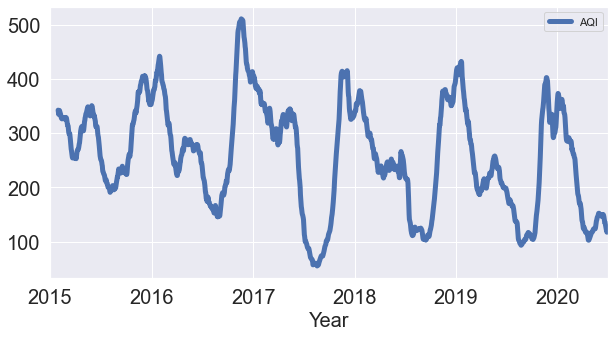

In [98]:
aqi = df_serie[['AQI']]
aqi.rolling(30).mean().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Mensualmente se observa un ligero cambio decreciente en la tendencia de la serie.

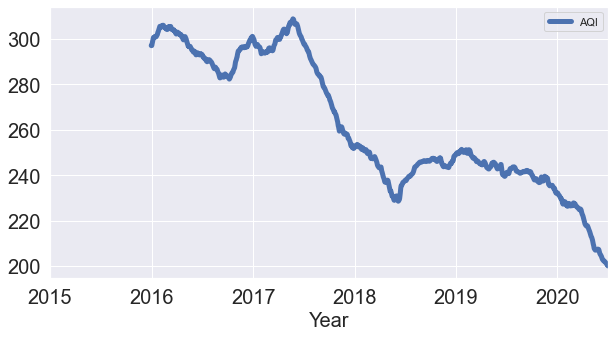

In [99]:
aqi = df_serie[['AQI']]
aqi.rolling(365).mean().plot(figsize=(10,5), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);

Con base en la gráfica podemos ver que hay una tendencia decreciente en general, alcanza su punto mínimo alrededor del año 2018, vuelve a aumentar en el año 2019 y finalmente sigue disminuyendo.

**Estacionariedad**

Gráficamente se evidencia que la serie de tiempo oscila sobre el mismo valor, conservando la misma media a lo largo del tiempo y una varianza constante, lo cual nos permite afirmar que la serie es homocedástica. Realizaremos la prueba de Dickey Fuller para validar si la serie es estacionaria:

In [16]:
result = adfuller(df_serie['AQI'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.431934
p-value: 0.009917
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


El p-valor es menor a un nivel de significancia del 5, por tal motivo se rechaza la hipotesis nula y se puede concluir que hay evidencia estadística para afirmar que la serie de tiempo es estacionaria, por lo tanto, no es necesario diferenciar.

**Periodicidad and Autocorrelación**

Para validar si existe periodicidad o autocorrelación, haremos un plot de autocorrelación:

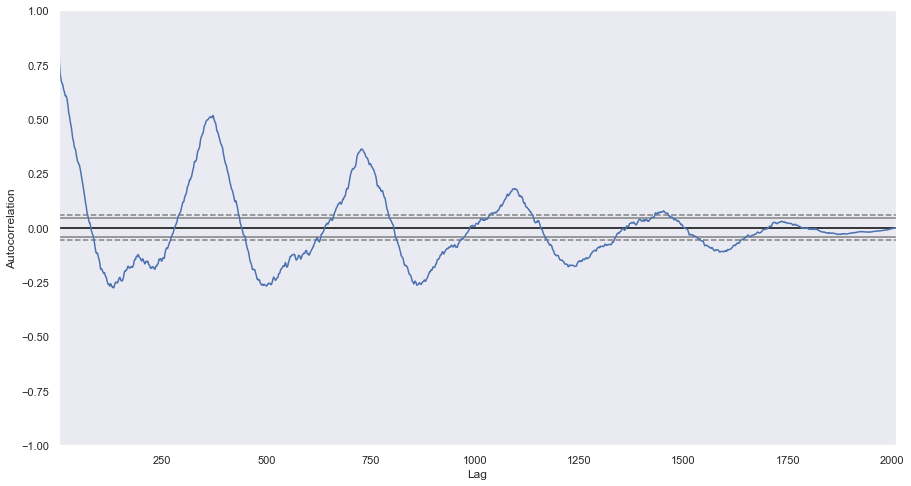

In [17]:
plt.figure(figsize=(15,8))
pd.plotting.autocorrelation_plot(aqi);

Se observa que hay un pico de correlación cada 365 días (lag), de igual forma, se observa este pico a los 730 días, lo que indica que la serie está correlacionada consigo misma. Dado que la serie sobre pasa las lineas punteadas existe evidencia estadística para afirmar que existe correlación, en este caso la serie del índice de calidad de aire es autocorrelacionada con un lag de un año. También identificamos que hay periodicidad cada 365 días.

**Gráficas de autocorrelación y autocorrelación parcial**

Para identificar el orden p y q de los modelos AR y MA respectivamente, se realizarán las gráficas de autocorrelación y autocorrelación parcial.

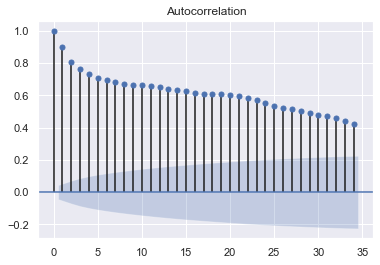

In [18]:
plot_acf(aqi);

Como tiene un descenso gradual, se concluye que la serie es autoregresiva.

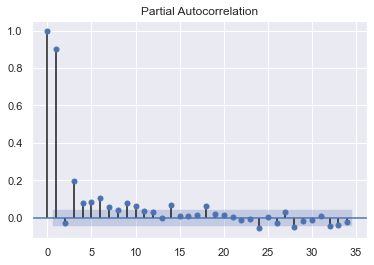

In [19]:
plot_pacf(aqi);

Con la gráfica de autocorrelación parcial se observa que tiene un orden p autoregresivo de dos. Por lo tanto se ajustará un modelo ARIMA de orden (2,0,0), ya que como se observó anteriormente no es necesario diferenciar.

**Ajuste de serie temporal ARIMA**

In [20]:
model = ARIMA(aqi, order=(2,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:                    AQI   No. Observations:                 2009
Model:                     ARMA(2, 0)   Log Likelihood              -10769.672
Method:                       css-mle   S.D. of innovations             51.488
Date:                Sun, 18 Jul 2021   AIC                          21547.343
Time:                        18:35:11   BIC                          21569.765
Sample:                    01-01-2015   HQIC                         21555.574
                         - 07-01-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        258.8766     11.541     22.432      0.000     236.257     281.496
ar.L1.AQI      0.9288      0.022     41.655      0.000       0.885       0.972
ar.L2.AQI     -0.0279      0.022     -1.248      0.2

**Errores residuales**

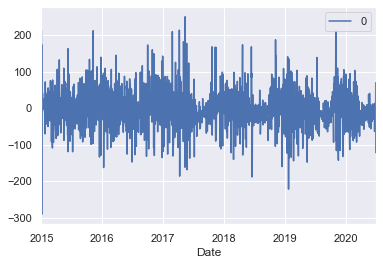

In [21]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

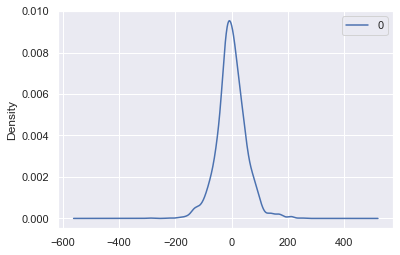

                 0
count  2009.000000
mean     -0.091405
std      51.679915
min    -291.160847
25%     -28.241981
50%      -1.719873
75%      28.082613
max     250.230715


In [22]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Con la gráfica de densidad de los residuales, se cumple el supuesto de que estos errores deben ser gaussianos.

**4. Predicciones**

Se ajustarán diferentes modelos de análisis de series temporales, entre los cuales se probarán ARIMA y Prophet, para encontrar el que mejor MSE tenga. Para esto se dividirá la base en entrenamiento y prueba.

In [70]:
X = aqi
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

**ARIMA**

El ARIMA se corre con los mismos parámetros obtenidos en el numeral anterior (2,0,0).

In [81]:
model = ARIMA(train, order=(2,0,0))
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=len(test))[0]
yhat = output
predictions = yhat
real_values = list(test['AQI'])

print(pd.DataFrame({'predict':predictions, 'real':real_values}))

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


        predict   real
0    127.069961   90.0
1    143.335896  100.0
2    157.815211  138.0
3    170.702518  105.0
4    182.172843   91.0
..          ...    ...
679  275.023907  112.0
680  275.023907  196.0
681  275.023907  233.0
682  275.023907  114.0
683  275.023907  101.0

[684 rows x 2 columns]


**MSE**

In [82]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 15922.857


**Real vs. Predicho**

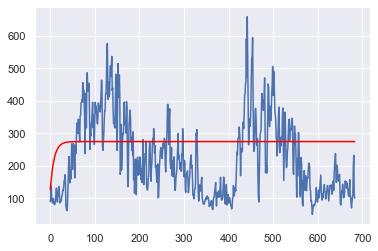

In [83]:
plt.plot(real_values)
plt.plot(predictions, color='red')
plt.show()

Se evidencia que el modelo ajustado ARIMA, no obtiene una buena predicción, teniendo en cuenta que la función de pronóstico de un modelo autogresivo tiende a la media. Adicionalmente, probamos con diferentes parámetros en p, d y q obteniendo resultados semejantes o incluso con peor desempeño en la predicción.

Es por eso que se recomienda usar otros tipos de modelo como SARIMA, ARIMAX o Prophet. Este último modelo se ajustará a continuación.

**Prophet**

Ajuste de un modelo con prophet:

In [86]:
df_prophet = df_serie.reset_index()
df_prophet.columns = ['ds','y']

size = int(len(df_prophet) * 0.66)
train, test = df_prophet[0:size], df_prophet[size:len(df_prophet)]

m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [89]:
future = df_prophet[['ds']]

Predicciones:

In [54]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2004,2020-06-27,213.825820,91.880326,324.966139
2005,2020-06-28,199.075168,75.690882,311.018543
2006,2020-06-29,187.400833,69.713778,307.374430
2007,2020-06-30,187.759312,66.171289,294.101436
2008,2020-07-01,190.171675,69.986557,304.246306


Gráfica entrenamiento y prueba:

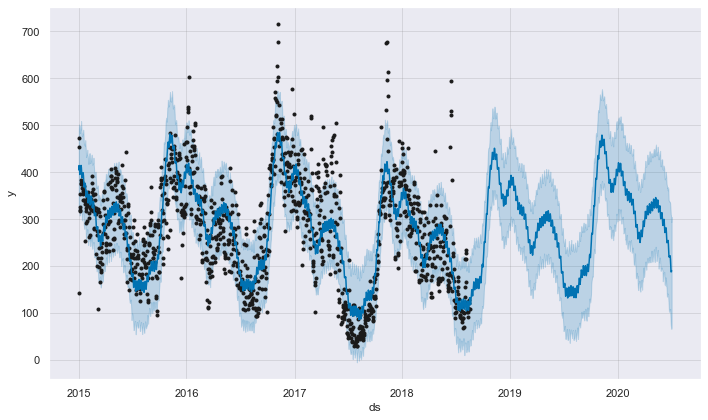

In [55]:
fig1 = m.plot(forecast)

In [57]:
size = int(len(forecast) * 0.66)
train_yhat, test_yhat = forecast[0:size], forecast[size:len(forecast)]

**MSE**

In [68]:
error = mean_squared_error(test['y'], test_yhat[['yhat']])
print('Test MSE: %.3f' % error)

Test MSE: 11573.406


El MSE encontrado en prophet es mejor que para el modelo ARIMA ajustado.

**Real vs. predicho**

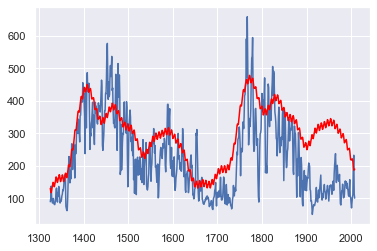

In [69]:
plt.plot(test['y'])
plt.plot(test_yhat[['yhat']], color='red')
plt.show()

**Componentes de la serie de tiempo**

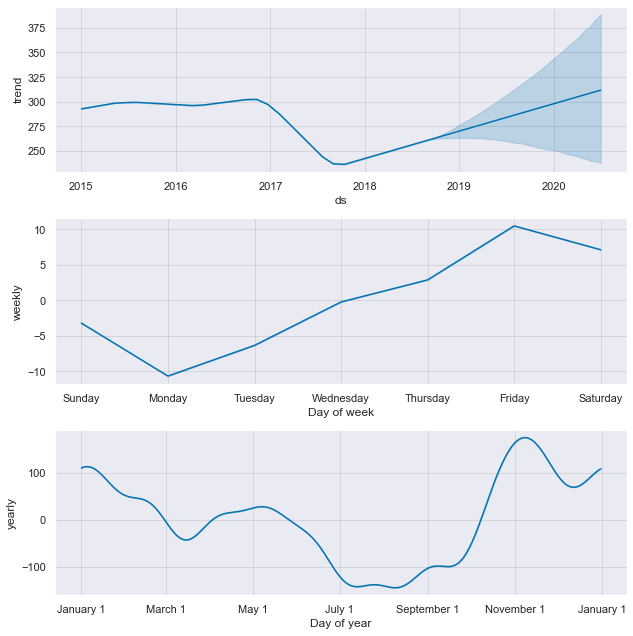

In [88]:
m.plot_components(forecast);

**5. Conclusiones**

1. Si bien solo teniamos un 0.49% de valores nulos, es necesario realizar una imputación para trabajar con series de tiempo.
2. Se observa que la serie de tiempo es estacionaria y presenta una periodicidad y autocorrelación anual.
3. Según las gráficas de autocorrelación y autocorrelación parcial los mejores parámetros del modelo arima son (2,0,0), dado que encontramos que era un modelo autogresivo de orden 2 y que no necesitaba diferenciación.
4. Los errores residuales tienen una distribución gaussiana.
5. Se probaron los modelos ARIMA y prophet, obteniendo un MSE de 15922.86 y 11573.41 respectivamente, por lo cual, el modelo prophet nos ofrece un mejor desempeño en la predicción.
6. La tendencia que se ve a través de los años, es que el AQI ha ido disminuyendo, por lo cual, la India ha ido mejorando su nivel de calidad de aire. 
7. El día viernes es cuándo se presenta un índice de calidad superior al resto de los días. El día con menor índice es el día lunes.
8. Al revisar la tendencia mensual, se observa que en noviembre es donde se presenta peor calidad de aire todos los años. Por el contrario, julio y agosto son los que presentan el mejor índice cada año.
9. La recomendación para el gobierno de Delhi-India es verificar cuales son las variables que están incidiendo para que los días viernes y el mes de noviembre tengan un nivel de polución superior y de esta manera tomar acciones para mejorarlo.
10. La India también podría revisar el compartamiento de los días lunes y los meses de julio y agosto en general, para identificar las buenas prácticas y replicarlo el resto del año.
11. Los entes ambientales de Delhi-India pueden usar el modelo ajustado, para predecir y tomar acciones preventivamente en caso de encontrar valores no deseados en el índice de calidad del aire.
12. Si bien al inicio veíamos que la India, tiene uno de los peores índices de calidad de aire, al menos es un aliciente observar que este no va a empeorar con el transcurso del tiempo, de acuerdo con los resultados obtenidos en el análisis.